In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
from collections import Counter

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import nltk
nltk.downloader.download('vader_lexicon')

import gensim
from gensim import corpora

In [3]:
# Read the data
# Source - https://www.reddit.com/r/datasets/comments/6yt3og/every_line_from_every_episode_of_the_office_us/

data = pd.read_excel("C:/Users/gandhip/Documents/LearnNLP/the-office-lines.xlsx")

In [4]:
# Restrict analysis to key characters
characs = ['Michael', 'Jim', 'Pam', 'Andy', 'Erin', 'Dwight', 'Kevin', 'Angela', 'Oscar', 'Ryan', 'Darryl', 'Phyllis',\
           'Kelly', 'Jan', 'Toby', 'Stanley', 'Holly', 'Creed', 'Meredith']

characs_lower = [x.lower() for x in characs]

## <font color=blue>Airtime of characters</font> 

In [5]:
# get proportion of number of words spoken by each character
data['no_words'] = data['line_text'].apply(lambda x: len(str(x).split(" ")))
word_cnt_df = data.groupby(['season','speaker'])['no_words'].sum()
word_share_df = word_cnt_df.groupby(level=0).apply(lambda x:x/x.sum()).reset_index()

# keep only top 5 characters by airtime in each season
word_share_plot = word_share_df.sort_values(['season', 'no_words'], ascending = [True, False]).\
                  rename(columns = {'no_words':'words_share'}).\
                  groupby('season').head(5)

Text(0.5,1,'Air time of top 5 characters across all seasons')

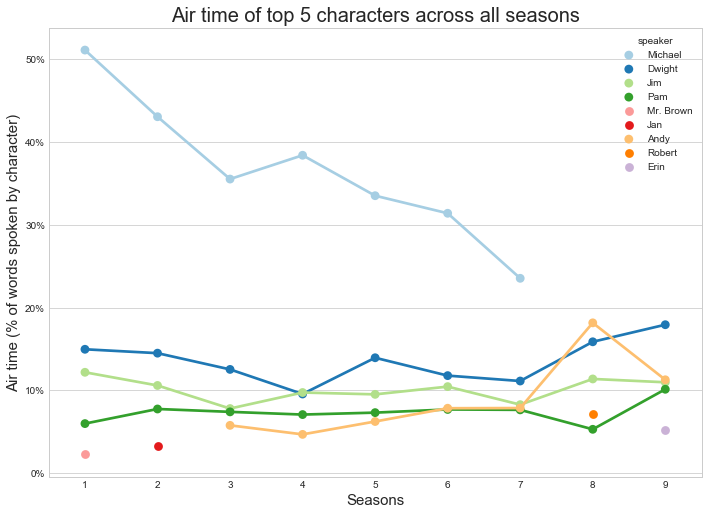

In [7]:
# Plot a pointplot

sns.set_palette("Paired", n_colors=20)
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(11.7, 8.27)) #increase size
pp = sns.pointplot(ax = ax, x = 'season', y = 'words_share', hue = 'speaker', figsize=(12,10), data = word_share_plot)
pp.set_xlabel("Seasons", fontsize = 15)
pp.set_ylabel("Air time (% of words spoken by character)", fontsize = 15)
pp.set_yticklabels(['{:,.0%}'.format(x) for x in pp.get_yticks()]) # display yaxis ticks as %
pp.set_title("Air time of top 5 characters across all seasons", fontsize = 20) 

## <font color= blue> Dialogue length by characters </font>

In [8]:
# subset for key characters and get all the speakers and their number of words in a line
dialogue_len = data.loc[data['speaker'].isin(characs), ['speaker','no_words']]

Text(0.5,1,'Distribution of # words spoken by key characters in a line')

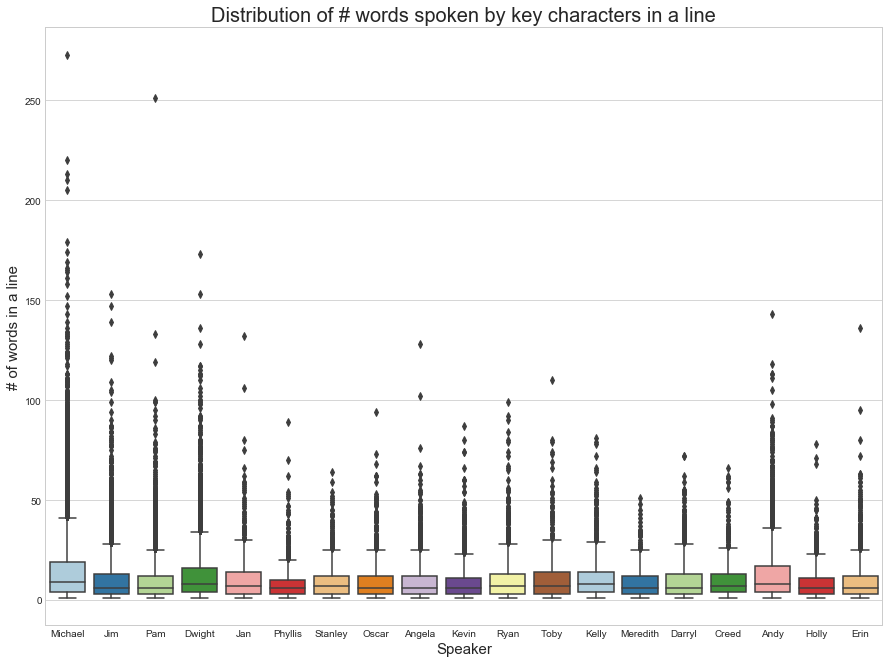

In [9]:
# plot distribution through boxplot 

sns.set_palette("Paired", n_colors=20)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(15, 11)) #increase size

bp = sns.boxplot(ax=ax, x=dialogue_len["speaker"], y=dialogue_len["no_words"])

bp.set_xlabel("Speaker", fontsize = 15)
bp.set_ylabel("# of words in a line", fontsize = 15)
bp.set_title("Distribution of # words spoken by key characters in a line", fontsize = 20) 

##  <font color= blue> Data pre-processing </font>

In [10]:
#removing punctuation \w is word character \s is space
data['cleaned_text'] = data['line_text'].str.replace("[^\w\d'\d\s]",'')

#converting to lowercase
data['cleaned_text'] = data['cleaned_text'].str.lower()

#stopwords removal
# Do this before stemming because stopwords include words like couldn't shouldn't which would change in stemming
stop = stopwords.words('english')
data['rm_stop_text'] = data['cleaned_text'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stop)]))

#stemming
stemmer = SnowballStemmer("english")
data['stemmed_words'] =data['rm_stop_text'].apply(lambda x: [stemmer.stem(word) for word in str(x).split()])
data.stemmed_words = data.stemmed_words.apply(', '.join).str.replace(',','')

##### Add additional stop words

In [11]:
# find the words that occur in more than n% (using 50% here) of episodes and remove them

#group text by each episode
episode_text = data.groupby(['season', 'episode'])['rm_stop_text'].apply(lambda x: x.str.cat(sep = " ")).reset_index()

# find unique words in each episode
episode_text['unique_words'] = episode_text['rm_stop_text'].apply(lambda x: ' '.join(np.unique(str(x).split()).tolist()))

# count # of episodes that each word occured in
freq_words_epi = pd.DataFrame(pd.Series(' '.join(episode_text.unique_words).split()).value_counts()).reset_index()
freq_words_epi.columns = ['words', 'count']

# create a list of words that occured in more than n% episodes 
# tried with and without characters in the stop word. because when this new column is used for topic modeling,
# topics come up with all words as character names
add_stop_wo_charac = freq_words_epi.loc[(freq_words_epi['count'] >= 0.5*len(episode_text)) & (~freq_words_epi['words'].isin(characs_lower)) \
                              , ['words']]
add_stop_list_wo_charac = list(add_stop_wo_charac['words'])

add_stop_with_charac = freq_words_epi.loc[(freq_words_epi['count'] >= 0.5*len(episode_text)), ['words']]
add_stop_list_with_charac = list(add_stop_with_charac['words'])

# add a new column with words not in the new stop list
data['rm_stop_text2_charac_prsnt'] = data['rm_stop_text'].apply(lambda x: ' '.join([word for word in str(x).split() \
                                                                       if word not in (add_stop_list_wo_charac)]))

data['rm_stop_text2_charac_rmvd'] = data['rm_stop_text'].apply(lambda x: ' '.join([word for word in str(x).split() \
                                                                       if word not in (add_stop_list_with_charac)]))

##  <font color= blue> Top words for each character </font>

In [12]:
# use text afte removing stop words instead of stemmed text beause we are interested in top words
# stemming alters the structure of words, which isn't desirable here
text_grp = data.groupby('speaker')['rm_stop_text'].apply(list).reset_index()

# analysis for selected characters only
data_com_word = text_grp[text_grp['speaker'].isin(characs)]

data_com_word['cleaned_text_str'] = data_com_word['rm_stop_text'].apply(','.join)
data_com_word['cleaned_text_str'] = data_com_word['cleaned_text_str'].str.replace(',',' ')

C:\Users\gandhip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\gandhip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [16]:
# Lot of non-key words also come into this list which werent removed by stopwords earlier
# So a new approach - look at top 100 words for each character and create a common word list for words whose frequency is atleast 10 10
# i.e. it comes as a top word among 100 for at least 10 of the characters
# Do not remove character names in this

#get top 100 words for each character
speaker_words = pd.DataFrame()
    
for row_index, row in data_com_word.iterrows():
    a = row['speaker']
    b = Counter(row['cleaned_text_str'].split()).most_common(100)
    tmp_data = [[a,b]]
    speaker_words = speaker_words.append(tmp_data)
    
speaker_words.columns = ['Speaker','key_words']

common100 = pd.DataFrame(speaker_words.key_words.values.tolist(), index= speaker_words.index)

colnames = list(common100.columns)
for k in colnames: 
        common100[k] = common100[k].astype(str)    
        common100[k]=common100[k].str.replace("[^a-zA-Z]",'')
        
# calculating the frequency of these 100 most common words that come for all characters
common100_melt = pd.melt(common100, var_name = "rank", value_name = "word")
common100_count = pd.DataFrame(common100_melt.word.value_counts()).reset_index()
common100_count.columns = ['word', 'count']

# create a list of words that occur in the list of at least 10 characters as most common
common_remove_words_df = common100_count[(common100_count['count'] >= 9) & (~common100_count['word'].isin(characs_lower))]
common_remove_words_list = list(common_remove_words_df['word'])

# adding some words which were removed when we tried to remove apostrophes at beggining and end of words
common_remove_words_list.extend(["i'm","i'll", "that's", "he's", "can't"]) 

In [17]:
# get the top 10 words for each character after removing the words from removed word list
speaker_words_10 = pd.DataFrame()
    
for row_index, row in data_com_word.iterrows():
    a = row['speaker']
    b = Counter(w for w in row['cleaned_text_str'].split() if w not in common_remove_words_list).most_common(10)
    tmp_data = [[a,b]]
    speaker_words_10 = speaker_words_10.append(tmp_data)

speaker_words_10.columns = ['Speaker','key_words']

speaker_words_10[['word1','word2','word3','word4','word5','word6','word7','word8','word9','word10']] \
    = pd.DataFrame(speaker_words_10.key_words.values.tolist(), index= speaker_words_10.index)
speaker_words_10.drop(['key_words'], axis = 1, inplace = True)

colnames = list(speaker_words_10.columns)

for k in colnames:
   if k!= 'Speaker': 
        speaker_words_10[k] = speaker_words_10[k].astype(str)    
        speaker_words_10[k]=speaker_words_10[k].str.replace('[^a-zA-Z]','')
        
speaker_words_10.set_index('Speaker', inplace = True)

In [18]:
speaker_words_10

,word1,word2,word3,word4,word5,word6,word7,word8,word9,word10
Speaker,,,,,,,,,,
Andy,dwight,erin,andy,tuna,jim,guy,were,whoa,michael,angela
Angela,dwight,kevin,pam,oscar,party,michael,andy,stop,senator,pum
Creed,creed,jim,michael,pam,ive,boss,guy,room,were,lets
Darryl,mike,na,jim,whats,andy,were,cool,val,real,darryl
Dwight,jim,michael,dwight,pam,wait,lets,schrute,paper,andy,angela
Erin,andy,michael,dwight,pam,gabe,erin,hi,stop,pete,were
Holly,michael,were,hi,kevin,together,fine,tonight,dunder,dad,holly
Jan,michael,pam,branch,were,dwight,anything,jan,excuse,lets,fine
Jim,dwight,pam,michael,alright,jim,wow,actually,were,lets,stop


##  <font color= blue> Topic modelling using LDA </font>
 https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/
 
 https://radimrehurek.com/gensim/tut1.html

In [20]:
speaker_text = data.groupby(['speaker','season', 'episode'])['rm_stop_text2_charac_rmvd'].apply(lambda x: x.str.cat(sep = " ")).\
                reset_index()
speaker_text = speaker_text[speaker_text['speaker'].isin(characs)]
top_topic_words = pd.DataFrame()
# characs_list = ['Michael', 'Andy']


for spk in characs:
    
    speaker_text_onechar = speaker_text.loc[speaker_text['speaker'] == spk]

    documents = list(speaker_text_onechar['rm_stop_text2_charac_rmvd'])

    texts = [[word for word in doc.lower().split()]
              for doc in documents]

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. 
    dictionary = corpora.Dictionary(texts)

    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in texts]

    # Creating the object for LDA model using gensim library
    Lda = gensim.models.ldamodel.LdaModel

    # Running and Trainign LDA model on the document term matrix.
    ldamodel = Lda(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50)

    # print(ldamodel.print_topics(num_topics=5, num_words=5))

    temp_list = []
    for t in range(ldamodel.num_topics):
        temp_list.extend([(t, ) + x for x in ldamodel.show_topic(t, topn = 5)])

    temp_df = pd.DataFrame(temp_list, columns = ['Topic', 'Word', 'P'])
    temp_df['Speaker'] = spk

    top_topic_words = top_topic_words.append(temp_df)


In [21]:
# restructure the dataframe to get all speakers as columns
top_words = top_topic_words[['Topic','Word','Speaker']]
top_words_pivot = top_words.pivot( columns='Speaker', values = 'Word')

# add topic number as a column
topic_list = []

for i in range(5):
    for k in range(5):
        topic_list.append(i)
        
top_words_pivot.insert(0, 'Topic_no', topic_list)
top_words_pivot

Speaker,Topic_no,Andy,Angela,Creed,Darryl,Dwight,Erin,Holly,Jan,Jim,Kelly,Kevin,Meredith,Michael,Oscar,Pam,Phyllis,Ryan,Stanley,Toby
0,0,im,cat,kids,na,manager,andy's,darryl,jan,im,tonight,eat,van,jan,towards,party,bob,wuphf,christmas,youre
1,0,tuna,senator,bratton,mike,ha,forget,aj,hour,dont,customer,pizza,lice,david,creed,christmas,cake,robert,clients,lets
2,0,dont,phillip,creed,da,schrute,box,accent,christian,thats,reason,bathroom,'em,party,treasure,eat,client,woof,song,hr
3,0,thats,robert,bankruptcy,cookies,im,indian,hours,discuss,cant,bridesmaid,party,fall,sort,case,michael's,luke,days,y2k,dont
4,0,youre,charles,soup,text,fire,gabe,mmm,tomorrow,cake,service,shred,ain't,hit,least,box,lost,private,gun,jan
5,1,erin,party,creed,im,schrute,party,todd,brenda,dwight's,fashion,warning,minute,jan,dollars,im,erin,top,florida,doll
6,1,bernard,cat,brown,mike,attention,erin,dollars,speakerphone,definitely,blah,phillip,shirt,party,invited,mural,hes,party,hudson,appropriate
7,1,darryl,dont,debbie,val,mr,gabe,correct,queen,pam's,kill,turn,kid,york,spend,darryl,cant,york,bonus,flenderson
8,1,bum,hour,quality,roy,christmas,andy's,b,michael's,dont,cute,party,christmas,fire,matt,party,bob,beet,game,file
9,1,tuna,cats,playing,thats,manager,andys,c,princess,wedding,romantic,fire,cake,darryl,happen,conference,clients,salesman,team,costa


##  <font color= blue> Sentiment Analysis </font>
https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/

https://nycdatascience.com/blog/student-works/sentiment-analysis-yelp-user-review-data/

In [23]:
# group lines by each speaker/season/episode and subset only selcted characters
speaker_text_senti = data.groupby(['speaker','season', 'episode'])['rm_stop_text'].apply(lambda x: x.str.cat(sep = " ")).\
                reset_index()
speaker_text_senti = speaker_text_senti[speaker_text_senti['speaker'].isin(characs)]

# Calculate the sentiment for each such group of line
sia = SIA()
senti_df = []

for index, row in speaker_text_senti.iterrows():
    pol_score = sia.polarity_scores(row['rm_stop_text'])
    speaker_text_senti.at[index,'pos_score'] = pol_score['pos']
    speaker_text_senti.at[index,'neg_score']  = pol_score['neg']
    speaker_text_senti.at[index,'neu_score']  = pol_score['neu']
    speaker_text_senti.at[index,'comp_score']  = pol_score['compound']

# mark any composite score less than -0.2 as negative, greater than 0.2 as positive and rest as neutral
speaker_text_senti['senti'] = "Neutral"
speaker_text_senti.loc[speaker_text_senti['comp_score'] < -0.2, 'senti'] = "Negative"
speaker_text_senti.loc[speaker_text_senti['comp_score'] > 0.2, 'senti'] = "Positive"

# aggregate number & % of lines of each sentiment for each speaker across seasons/episodes
senti_count = speaker_text_senti.groupby(['speaker', 'senti'])['speaker'].agg(['count'])
senti_pct = senti_count.groupby(level=0).apply(lambda x: x / (x.sum())).reset_index()

# pivot the dataframe to get all the sentiments as columns
senti_pct_pivot = senti_pct.pivot(index = 'speaker', columns = 'senti', values = 'count').reset_index()

# replace all NaNs by 0
senti_pct_pivot.fillna(0)
senti_pct_pivot.sort_values(['Positive', 'Negative'], ascending = [0,0], inplace = True)
senti_pct_pivot.set_index('speaker', inplace = True)

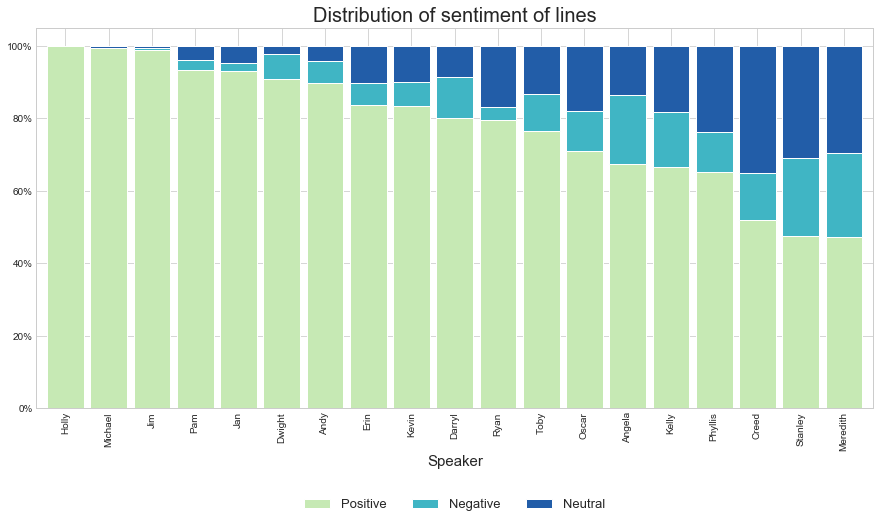

In [24]:
# plot the stacked bar chart

colors = sns.color_palette("YlGnBu", n_colors=3)
cmap1 = LinearSegmentedColormap.from_list("my_colormap", colors) # selecting the color scheme

sb = senti_pct_pivot.loc[:,['Positive','Negative', 'Neutral']].\
      plot(kind = 'bar', stacked=True, figsize=(15,7), width = 0.85, edgecolor='white', colormap = cmap1)
sb.set_facecolor('white') # background color
sb.set_title('Distribution of sentiment of lines', fontsize = 20)
sb.set_xlabel("Speaker", fontsize = 15)
sb.set_yticklabels(['{:,.0%}'.format(x) for x in sb.get_yticks()]) # display yaxis ticks as %
sb.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3, fancybox=True, shadow=True, fontsize = 13) 


##  <font color= blue> Scene Co-occurence </font>
https://nycdatascience.com/blog/student-works/tv-data-perspective-analysis-nbcs-office/

In [25]:
# subsetting data to selected characters
data_characs = data.loc[data['speaker'].isin(characs),]

# number of lines for each speaker in each scene/episode/season
df_grp = data_characs.groupby(['season','episode','scene','speaker'])['id'].count().reset_index()

# create a unique id for each scene (across episodes and seasons)
df_grp['unique_id'] = df_grp['season'].astype(str)+df_grp['episode'].astype(str)+df_grp['scene'].astype(str)

#sort by speaker with most number of lines in each scene
df_grp.sort_values(by = ['season','episode','scene','id'], ascending = [1,1,1,0], inplace = True)

# identify scenes with just 1 speaker
scene_cnt = df_grp[['speaker','unique_id']].groupby(['unique_id']).agg(['count']).reset_index()
scene_cnt.columns = ['unique_id','count']
scene_cnt_1 = scene_cnt.loc[scene_cnt['count']==1, ]

# remove all the scenes with just 1 speaker
df_grp_mlt = df_grp.loc[~df_grp['unique_id'].isin(scene_cnt_1['unique_id']), ['unique_id','speaker']]

# For simplicity of visualization, take only the top 2 (by # lines) speakers in each scene
df_grp_two = df_grp_mlt.groupby('unique_id').head(2).reset_index(drop = True)

# sort ascending by speaker within each scene so as the same order is maintained across, needed to get right structure when
# converted to a crosstab
df_grp_two.sort_values(by = ['unique_id','speaker'], ascending = [1,1], inplace = True)

# restructure the dataframe so as to get the first column as speaker 1 and 2nd as speaker 2 in each scene
df_grp_mlt2 = df_grp_two.groupby('unique_id')['speaker'].unique().apply(pd.Series).reset_index()
new_names = [(i, 'speaker_'+str(i)) for i in df_grp_mlt2.iloc[:, 1:].columns.values]
df_grp_mlt2.rename(columns = dict(new_names), inplace=True)

# convert the dataframe into a n*n matrix where n = number of characters
cocur_matrix = pd.crosstab(df_grp_mlt2.speaker_0, df_grp_mlt2.speaker_1)

# matrix skipped the first character in column and last in rows, so add it back after converting to datfarame
cocur_df = pd.DataFrame(cocur_matrix)
cocur_df['Andy'] = 0
cocur_df.loc['Toby'] = 0

# re-arrange columns so as to maintain same order in columns and rows
cols = list(cocur_df.columns)
cols = cols[-1:] + cols[:-1]
cocur_df = cocur_df[cols]

# copy the upper right triangle to lower left triangle in the crosstab so as to get a symmetric heatmap
for row in cocur_df.index.values:
    for column in cocur_df.columns.values:
       cocur_df[row][column] = cocur_df[column][row]

Text(88.8,0.5,'Speaker 1')

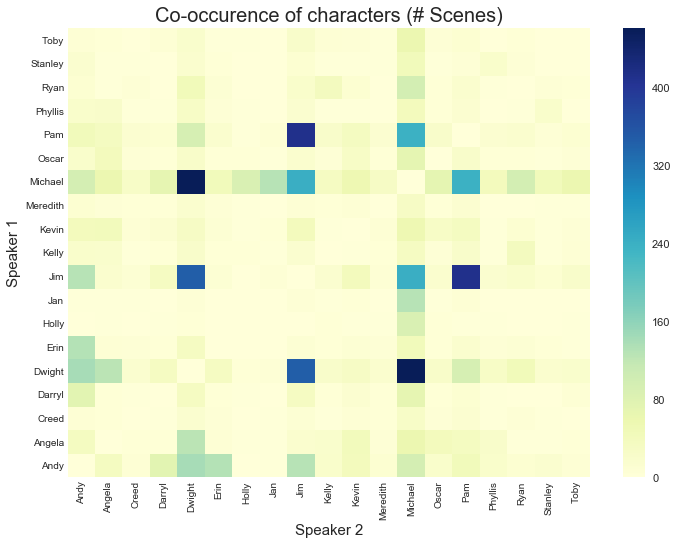

In [26]:
# plot the heatmap

fig, ax = plt.subplots(figsize=(11.7, 8.27)) #increase size
sns.set(font_scale=1.1)
hm = sns.heatmap(ax=ax, data = cocur_df, cmap="YlGnBu")
hm.invert_yaxis()
hm.set_title('Co-occurence of characters (# Scenes)', fontsize = 20)
hm.set_xlabel("Speaker 2",fontsize=15)
hm.set_ylabel("Speaker 1",fontsize=15)